In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [0]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

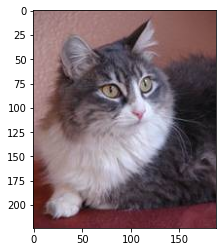

In [0]:
Train_dir = r"/content/gdrive/My Drive/Kaggle/training_set/training_set"
Test_dir = r"/content/gdrive/My Drive/Kaggle/test_set/test_set"

categories = ['cats','dogs']

for i in categories:
    path = os.path.join(Train_dir,i)
    for img in os.listdir(path):
        img = cv2.imread(os.path.join(path,img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.show()
        break
    break

In [0]:
img_size = 200

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
        Train_dir,
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='binary')

test_set = test_datagen.flow_from_directory(
        Test_dir,
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='binary')

Using TensorFlow backend.


Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


(32, 200, 200, 3) (32,)


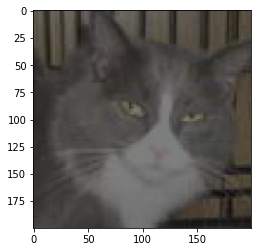

(32, 200, 200, 3) (32,)


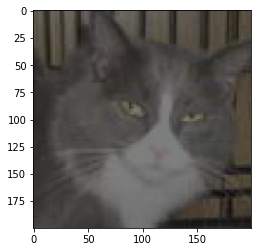

In [0]:
# test training generator
for _ in training_set:
    print(_[0].shape, _[1].shape)
    plt.imshow(np.clip(_[0][0] / 2. , 0, 1))
    plt.show()

    print(_[0].shape, _[1].shape)
    plt.imshow(np.clip(_[0][0] / 2. , 0, 1))
    plt.show()
    break

In [0]:
import keras
from keras import backend as K

In [0]:
def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    model = keras.applications.InceptionV3(include_top=False, input_shape=(img_size, img_size, 3),
                                          weights='imagenet' if use_imagenet else None)
    # add global pooling just like in InceptionV3
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    # add new dense layer for our labels
    new_output = keras.layers.Dense(1, activation='sigmoid')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [0]:
model = inception()

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 99, 99, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 99, 99, 32)   96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 99, 99, 32)   0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

In [0]:
print(len(model.layers))

313


In [0]:
# set all layers trainable by default
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.9
    
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
    # fix all but batch norm layers, because we neeed to update moving averages for a new dataset!
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

In [0]:
# compile new model
model.compile(
    loss='binary_crossentropy',  # we train 102-way classification
    optimizer=keras.optimizers.adamax(lr=1e-2),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

In [0]:
# fine tune for 2 epochs (full passes through all training data)
# we make 2*8 epochs, where epoch is 1/8 of our training data to see progress more often
model.fit_generator(
    training_set,
    steps_per_epoch=8005 // 32 // 8, 
    epochs=4,
    validation_data = test_set,
    validation_steps=2023 // 32 // 4, 
    verbose=1,
    initial_epoch = 0
)

Epoch 1/4
31/31 [==============================] - 61s 2s/step - loss: 0.0596 - accuracy: 0.9798 - val_loss: 0.0090 - val_accuracy: 0.9771
Epoch 2/4
31/31 [==============================] - 122s 4s/step - loss: 0.0618 - accuracy: 0.9728 - val_loss: 0.0186 - val_accuracy: 0.9792
Epoch 3/4
31/31 [==============================] - 58s 2s/step - loss: 0.0647 - accuracy: 0.9728 - val_loss: 0.0440 - val_accuracy: 0.9688
Epoch 4/4
31/31 [==============================] - 83s 3s/step - loss: 0.0847 - accuracy: 0.9667 - val_loss: 0.0282 - val_accuracy: 0.9688


In [0]:
model.evaluate_generator(test_set,verbose=1)

64/64 [==============================] - 10s 149ms/step


[8.350270036316942e-06, 0.9708353877067566]

In [0]:
probabilities = model.predict_generator(test_set)

In [0]:
probabilities

array([[4.0361682e-01],
       [2.2689363e-07],
       [7.3115109e-04],
       ...,
       [3.6047370e-04],
       [9.9999988e-01],
       [1.0000000e+00]], dtype=float32)

(32, 200, 200, 3) (32,)


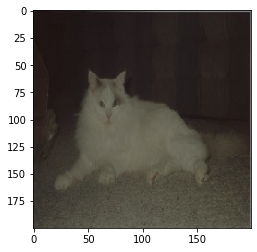

(32, 200, 200, 3) (32,)


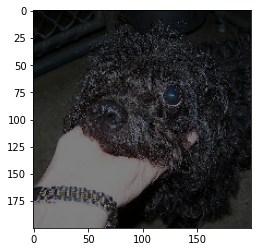

(32, 200, 200, 3) (32,)


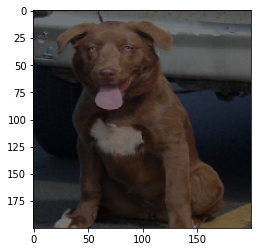

(32, 200, 200, 3) (32,)


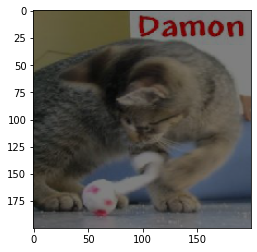

(32, 200, 200, 3) (32,)


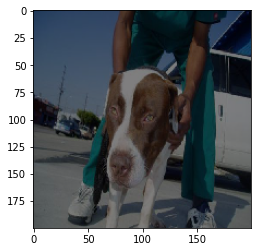

In [0]:
# test training generator
pp = 0
for _ in test_set:
    if(pp == 5):
      break
    print(_[0].shape, _[1].shape)
    plt.imshow(np.clip(_[0][0] / 2. , 0, 1))
    plt.show()
    pp = pp +1

(200, 200, 3)
[[0.9999968]]


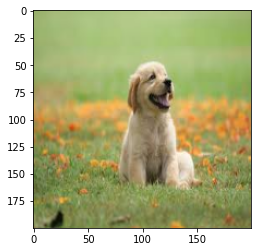

In [0]:
img = cv2.imread('/content/predict/dog_1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(img_size,img_size))
print(img.shape)
plt.imshow(img)

x = np.array(img)
x = x/255
x = x.reshape(1,200,200,3)

pred = model.predict(x)

print(pred)

In [0]:
model.save("fine_cat_dog.h5") #using h5 extension
print("model save!!!")


# from keras.models import load_model

# model = load_model('my_model.h5')
# model.summary()

model save!!!
